## Audio Classification using PyTorch
============================================

This notebook trains a CNN model on the Quran recitations dataset to classify audio samples into different classes.

In [1]:
import os
import time
import torch
import librosa

# Load the required libraries for audio processing and deep learning
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.transform import resize  # For resizing spectrograms
from sklearn.preprocessing import LabelEncoder  # For encoding class labels


# Set the device to use (GPU or CPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using *{device}* device")

Using *cuda* device


In [2]:
# Load the dataset from a CSV file
data_df = pd.read_csv('data/quran-recitations/files_paths.csv')

# Normalize file paths by prepending the data directory path
data_df['FilePath'] = "./data/quran-recitations/Dataset" + data_df['FilePath'].str[1:]

# Display the first few rows of the dataset
data_df.head()

,FilePath,Class
0,./data/quran-recitations/Dataset/Dataset/Moham...,Mohammed_Aluhaidan
1,./data/quran-recitations/Dataset/Dataset/Moham...,Mohammed_Aluhaidan
2,./data/quran-recitations/Dataset/Dataset/Moham...,Mohammed_Aluhaidan
3,./data/quran-recitations/Dataset/Dataset/Moham...,Mohammed_Aluhaidan
4,./data/quran-recitations/Dataset/Dataset/Moham...,Mohammed_Aluhaidan


In [3]:
print(f"There are {data_df.Class.nunique()} unique classes in the dataset: \n\n{data_df.Class.unique()}")

There are 12 unique classes in the dataset: 

['Mohammed_Aluhaidan' 'Yasser_Aldossary' 'Maher_Almuaiqly'
 'Nasser_Alqutami' 'AbdulBari_Althubaity' 'Bander_Balilah'
 'Ali_Alhothaify' 'Saud_Alshuraim' 'Mohammed_Ayoub' 'AbdulRahman_Alsudais'
 'Saad_Alghamdi' 'Abdullah_Albuaijan']


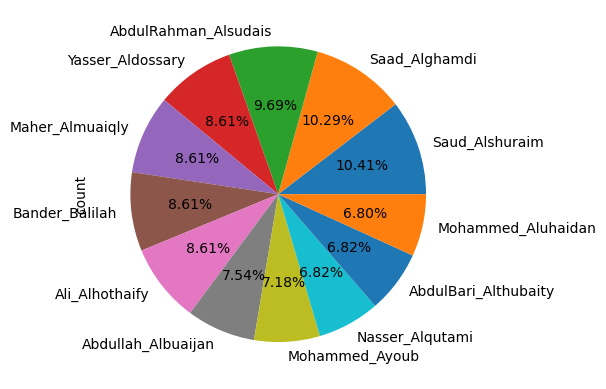

In [4]:
# Plot the distribution of class frequencies using matplotlib

# data_df.Class.value_counts().plot(kind='barh', figsize=(10, 5));
data_df.Class.value_counts().plot(kind='pie', autopct='%1.2f%%');

In [5]:
train_df = data_df.sample(frac=0.7, random_state=42)
test_df = data_df.drop(train_df.index)

val_df = test_df.sample(frac=0.5, random_state=42)
test_df = test_df.drop(val_df.index)

print(f"There are {len(train_df)} training samples")
print(f"There are {len(test_df)} testing samples")
print(f"There are {len(val_df)} validation samples")

There are 4681 training samples
There are 1003 testing samples
There are 1003 validation samples


In [6]:
encoder = LabelEncoder()
encoder.fit(train_df.Class.values);

In [7]:
# Audio Classification using PyTorch

class CustomAudioDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.labels = torch.tensor(encoder.transform(df.Class)).long().to(device)
        self.audios = [torch.tensor(self.get_spectrogram(path)).float().to(device) for path in df.FilePath]

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        return self.audios[idx].unsqueeze(0), self.labels[idx]

    # Define a function to compute the spectrogram of an audio file
    def get_spectrogram(self, path):
        # Load the parameters for spectrogram computation
        duration = 5                        # Duration of the spectrogram (seconds)
        sample_rate = 22050                 # Sample rate of the audio file (Hz)

        # Load the audio signal from the file using librosa's load function
        # This function returns a tuple containing the signal and its sampling rate
        signal, sr = librosa.load(path, sr=sample_rate, duration=duration)

        # Compute the mel-spectrogram of the audio signal
        spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=128, hop_length=512, n_fft=2048)

        # Convert the spectrogram to decibels using librosa's power_to_db function
        spec_db = librosa.power_to_db(spec, ref=np.max)

        # Resize the spectrogram to a fixed size using scipy's resize function
        spec_resized = librosa.util.fix_length(spec_db, size=(duration * sample_rate) // 512 + 1)

        # Use scikit-image's resize function with anti-aliasing enabled to resample the spectrogram
        spec_resized = resize(spec_resized, (128, 256), anti_aliasing=True)

        return spec_resized


# Create instances of the CustomAudioDataset class for training, testing, and validation
train_dataset = CustomAudioDataset(train_df)
test_dataset = CustomAudioDataset(test_df)
val_dataset = CustomAudioDataset(val_df)

print(f"There are {len(train_dataset)} training samples")

There are 4681 training samples


In [8]:
train_dataset.__getitem__(0)

(tensor([[[-31.1048, -35.0682, -45.4839,  ...,   0.0000,   0.0000,   0.0000],
          [-30.9353, -35.2693, -41.3763,  ...,   0.0000,   0.0000,   0.0000],
          [-29.0752, -32.9137, -42.8448,  ...,   0.0000,   0.0000,   0.0000],
          ...,
          [-33.5499, -31.3640, -29.6117,  ...,   0.0000,   0.0000,   0.0000],
          [-36.9432, -34.3699, -32.1902,  ...,   0.0000,   0.0000,   0.0000],
          [-54.5758, -50.8345, -47.9204,  ...,   0.0000,   0.0000,   0.0000]]],
        device='cuda:0'),
 tensor(6, device='cuda:0'))

In [9]:
LR = 1e-4
EPOCHS = 10
BATCH_SIZE = 16
NUM_CLASSES = data_df.Class.nunique()

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Model Architecture

We will be using a Convolutional Neural Network (CNN) architecture for audio classification tasks.

In [10]:
import torch
import torch.nn as nn

## Model Architecture

class Net(nn.Module):
    """
    A CNN model for audio classification tasks.

    Args:
        None

    Returns:
        torch.tensor: The output of the model.
    """
    def __init__(self):
        # Initialize the parent class (nn.Module) in the subclass
        super().__init__()

        # Create a 2D convolutional layer with 16 filters, kernel size of 3x3, and padding of 1
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)

        # Create another 2D convolutional layer with 32 filters, kernel size of 3x3, and padding of 1
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        # Create a third 2D convolutional layer with 64 filters, kernel size of 3x3, and padding of 1
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # Define a max pooling layer with kernel size of 2x2
        self.pooling = nn.MaxPool2d(kernel_size=(2, 2))

        # Define a ReLU activation function
        self.relu = nn.ReLU()

        # Flatten the output of the convolutional and pooling layers
        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear((16 * 32 * 64), 4096)
        self.linear2 = nn.Linear(4096, 1024)
        self.linear3 = nn.Linear(1024, 512)
        self.output = nn.Linear(512, NUM_CLASSES)

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pooling(x)

        x = self.conv2(x)
        x = self.pooling(x)

        x = self.conv3(x)
        x = self.pooling(x)

        x = self.relu(x)

        x = x.view(x.size(0), -1)

        x = self.flatten(x)

        x = self.linear1(x)
        x = self.dropout(x)

        x = self.linear2(x)
        x = self.dropout(x)

        x = self.linear3(x)
        x = self.dropout(x)

        x = self.output(x)

        return x


model = Net().to(device)
print(model)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=32768, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=12, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [11]:
from torchsummary import summary
summary(model, (1, 128, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 256]             160
         MaxPool2d-2          [-1, 16, 64, 128]               0
            Conv2d-3          [-1, 32, 64, 128]           4,640
         MaxPool2d-4           [-1, 32, 32, 64]               0
            Conv2d-5           [-1, 64, 32, 64]          18,496
         MaxPool2d-6           [-1, 64, 16, 32]               0
              ReLU-7           [-1, 64, 16, 32]               0
           Flatten-8                [-1, 32768]               0
            Linear-9                 [-1, 4096]     134,221,824
          Dropout-10                 [-1, 4096]               0
           Linear-11                 [-1, 1024]       4,195,328
          Dropout-12                 [-1, 1024]               0
           Linear-13                  [-1, 512]         524,800
          Dropout-14                  [

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

train_loss_history = []
val_loss_history = []

train_accuracy_history = []
test_accuracy_history = []


for epoch in range(EPOCHS):
    train_loss = train_acc = 0.0
    val_loss = val_acc = 0.0

    for audios, labels in train_loader:
        output = model(audios)

        loss = criterion(output, labels)
        train_loss += loss.item()
        
        train_acc += (output.argmax(1) == labels).sum().item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss_history.append(round(train_loss / 1000, 4))
    train_accuracy_history.append(round((train_acc / len(train_dataset)) * 100, 4))

    with torch.no_grad():
        for audios, labels in val_loader:
            output = model(audios)

            val_loss += criterion(output, labels).item()
            val_acc += (output.argmax(1) == labels).sum().item()
        
    val_loss_history.append(round(val_loss / 1000, 4))
    test_accuracy_history.append(round((val_acc / len(val_dataset)) * 100, 4))

    print(f"Epoch: {epoch+1} / {EPOCHS} | Train Loss: {train_loss_history[-1]:.4f} | Val Loss: {val_loss_history[-1]:.4f} | Train Acc: {train_accuracy_history[-1]:.4}% | Val Acc: {test_accuracy_history[-1]:.4}%")


Epoch: 1 / 10 | Train Loss: 0.8227 | Val Loss: 0.0424 | Train Acc: 48.94% | Val Acc: 79.96%
Epoch: 2 / 10 | Train Loss: 0.1403 | Val Loss: 0.0284 | Train Acc: 84.77% | Val Acc: 85.94%
Epoch: 3 / 10 | Train Loss: 0.0736 | Val Loss: 0.0177 | Train Acc: 92.14% | Val Acc: 91.53%
Epoch: 4 / 10 | Train Loss: 0.0565 | Val Loss: 0.0160 | Train Acc: 94.17% | Val Acc: 92.32%
Epoch: 5 / 10 | Train Loss: 0.0421 | Val Loss: 0.0157 | Train Acc: 95.68% | Val Acc: 92.82%
Epoch: 6 / 10 | Train Loss: 0.0381 | Val Loss: 0.0227 | Train Acc: 96.01% | Val Acc: 90.73%
Epoch: 7 / 10 | Train Loss: 0.0391 | Val Loss: 0.0195 | Train Acc: 96.07% | Val Acc: 92.72%
Epoch: 8 / 10 | Train Loss: 0.0321 | Val Loss: 0.0180 | Train Acc: 96.69% | Val Acc: 92.82%
Epoch: 9 / 10 | Train Loss: 0.0372 | Val Loss: 0.0188 | Train Acc: 96.45% | Val Acc: 93.22%
Epoch: 10 / 10 | Train Loss: 0.0313 | Val Loss: 0.0201 | Train Acc: 96.92% | Val Acc: 92.32%


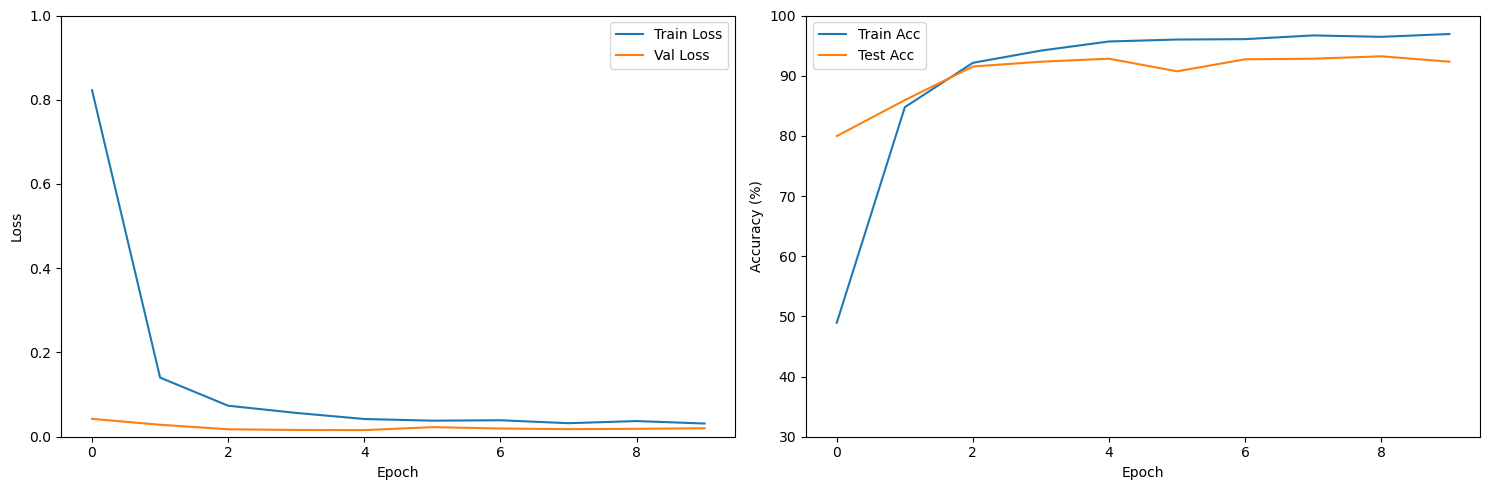

: 

In [17]:
# Subplots for the loss and accuracy history
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(train_loss_history, label='Train Loss')
axs[0].plot(val_loss_history, label='Val Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 1])
axs[0].legend()

axs[1].plot(train_accuracy_history, label='Train Acc')
axs[1].plot(test_accuracy_history, label='Test Acc')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].set_ylim([30, 100])
axs[1].legend()

plt.tight_layout()
plt.show()

In [14]:
test_acc = 0

with torch.no_grad():
    for audios, labels in test_loader:
        output = model(audios)
        test_acc += (output.argmax(1) == labels).sum().item()

print(f'Test accuracy: {(test_acc / len(test_dataset)) * 100 : .4f}%')

Test accuracy:  92.9212%
